In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import rasterio as rio
import geopandas as gp

import fiona 
import rasterio
import rasterio.mask

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

from rasterio.mask import mask
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from matplotlib.lines import Line2D      
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm

import matplotlib.pyplot as plt
from collections import OrderedDict 

from osgeo import gdal, osr, ogr
from tqdm import tqdm
from scipy import stats, spatial, signal, fftpack


In [201]:
stn_id = 'ORO'

# study period 
dt_idx = pd.date_range('2003-10-01','2021-09-30', freq='D')

# Read watershed gdf
stn_gdf = gp.read_file("../shape/{}.shp".format(stn_id))

# Read runoff
bf = pd.read_csv("../data/baseflow_sep/baseflow_mm.csv")
bf['date'] = pd.to_datetime(bf['date'])
bf.set_index("date", inplace = True)    
sr = pd.read_csv("../data/baseflow_sep/surface_runoff_mm.csv") 
sr['date'] = pd.to_datetime(sr['date'])
sr.set_index("date", inplace = True)   

# Read rainfall and snowmelt data
smlt_fn_1d = "../data/Watersheds/{}_smlt.npy".format(stn_id)
prcp_fn_1d = "../data/Watersheds/1d/{}_1d_prcp.npy".format(stn_id)

smlt = np.load(smlt_fn_1d)
prcp = np.load(prcp_fn_1d)

# filter the runoff data to select watershed
sr_df = pd.DataFrame(sr[stn_id].interpolate(how = 'linear'))[:-1]
bf_df = pd.DataFrame(bf[stn_id].interpolate(how = 'linear'))[:-1]

(12326.0, 18900.0)

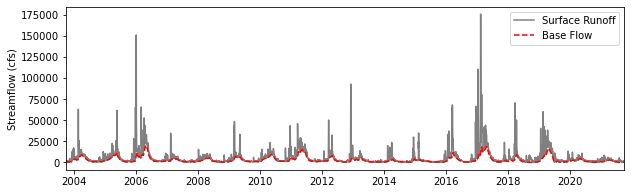

In [202]:
plt.figure(figsize = (10,3))
plt.plot(bf_df.index, bf_df['ORO']+ sr_df['ORO'], color = 'gray', label = 'Surface Runoff') 
plt.plot(bf_df.index, bf_df['ORO'], linestyle = "--", color = 'red', label = 'Base Flow') 
plt.legend()
plt.ylabel("Streamflow (cfs)")
plt.xlim([bf_df.index[0], bf_df.index[-1]])


In [203]:
# SMLT AND PRECIP DATA

In [204]:
smlt_sum = [np.nansum(smlt[:,:,x]) for x in range(0,smlt.shape[2])]
prcp_sum = [np.nansum(prcp[:,:,x]) for x in range(0,prcp.shape[2])]

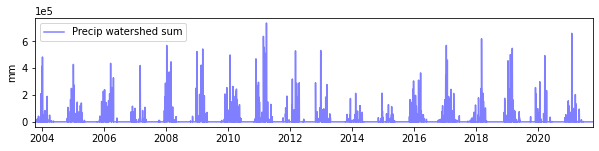

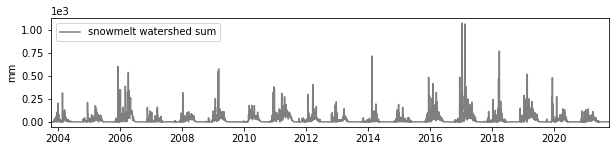

In [205]:
plt.figure(figsize = (10,2))
plt.plot(bf_df.index, prcp_sum, color = 'blue', alpha = 0.5, label = "Precip watershed sum")
plt.legend(loc = 'upper left')
plt.xlim([bf_df.index[0], bf_df.index[-1]])
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.ylabel("mm")

plt.figure(figsize = (10,2))
plt.plot(bf_df.index, smlt_sum, color = 'black', alpha = 0.5, label = "snowmelt watershed sum")
plt.legend(loc = 'upper left')
plt.xlim([bf_df.index[0], bf_df.index[-1]])
plt.ylabel("mm")
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

<ipython-input-231-9b3c1435b4dc>:5: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  window = (dt_idx[dt_idx > "2017-02-01"] & dt_idx[dt_idx <= "2017-02-10"])
<ipython-input-231-9b3c1435b4dc>:18: RuntimeWarning: Mean of empty slice
  smlt_anom = (np.nanmean(smlt_ims, axis = 2) - np.nanmean(smlt, axis = 2)) / np.nanmean(smlt, axis = 2)
<ipython-input-231-9b3c1435b4dc>:19: RuntimeWarning: Mean of empty slice
  prcp_anom = (np.nanmean(prcp_ims, axis = 2) - np.nanmean(prcp, axis = 2)) / np.nanmean(prcp, axis = 2)


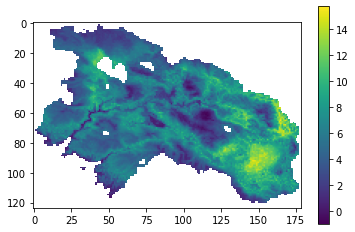

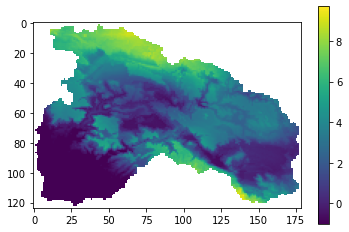

In [231]:
# The snowmelt and precip anomalies for Dec/16 - Feb 10 / 17 

dt_idx = bf_df.index

window = (dt_idx[dt_idx > "2017-02-01"] & dt_idx[dt_idx <= "2017-02-10"])

ts = bf_df.copy()
ts['dt'] = ts.index
ts.reset_index(inplace = True)
start = ts[ts.dt == window[0]].index
end = ts[ts.dt == window[-1]].index

s, e = int(start.values), int(end.values)

smlt_ims = smlt[:,:,s:e+1]
prcp_ims = prcp[:,:,s:e+1]

smlt_anom = (np.nanmean(smlt_ims, axis = 2) - np.nanmean(smlt, axis = 2)) / np.nanmean(smlt, axis = 2)
prcp_anom = (np.nanmean(prcp_ims, axis = 2) - np.nanmean(prcp, axis = 2)) / np.nanmean(prcp, axis = 2)

plt.imshow(smlt_anom); plt.colorbar(); plt.show()
plt.imshow(prcp_anom); plt.colorbar(); plt.show()


In [227]:
def normalize(x):
	return(x-np.nanmin(x))/(np.nanmax(x)- np.nanmin(x))

def standardize(x):
    scaled = (x - np.nanmean(x)) / np.nanstd(x);
    scaled[np.isnan(x)] = 0
    return scaled

imstack = prcp.copy()
imgmean = np.nanmean(imstack, axis = 2)

qarr = sr_df['ORO'].values
b=qarr.copy()

rows, cols, time = imstack.shape
px_ts = []
rclist = []

# extract pixelwise timeseries
for row in range(rows):
    for col in range(cols):
        
        if imgmean[row,col] == np.nan:
            continue
            
#         if not np.isnan(ts_arr).all():
        ts_arr = imstack[row,col,:]
        ts_arr[np.isnan(ts_arr)] = 0
        px_ts.append(pd.Series(ts_arr))
        rclist.append([row,col])

pxdf = pd.concat(px_ts, axis = 1)
pxdf.columns = pxdf.columns.map(str)

# Build the out image
lagim = np.zeros_like(np.mean(imstack, axis = 2))
corrim = np.zeros_like(np.mean(imstack, axis = 2))
pvalim = np.zeros_like(np.mean(imstack, axis = 2))

# Populate the per-pixel lags 
for rc, dfcolidx in tqdm(list(zip(rclist,pxdf.columns))[:]):
    
    a=pxdf[dfcolidx].values
    A = fftpack.fft(standardize(a))
    B = fftpack.fft(standardize(b))
    Ar = -A.conjugate()
    shiftval = np.argmax(np.abs(fftpack.ifft(Ar*B))[:365]) 
    
    try:
        corrcoef = stats.pearsonr(a,b)
        corr = corrcoef[0]
        pval = corrcoef[1]
    except:
        pval = np.nan
        corr = np.nan

    # fill ims
    rowidx, colidx = rc
    lagim[rowidx,colidx] = shiftval
    corrim[rowidx,colidx] = abs(corr)
    pvalim[rowidx,colidx] = pval



<ipython-input-227-bb83ba011c09>:10: RuntimeWarning: Mean of empty slice
  imgmean = np.nanmean(imstack, axis = 2)
  0%|          | 0/22196 [00:00<?, ?it/s]<ipython-input-227-bb83ba011c09>:5: RuntimeWarning: invalid value encountered in true_divide
  scaled = (x - np.nanmean(x)) / np.nanstd(x);
100%|██████████| 22196/22196 [00:44<00:00, 494.51it/s]


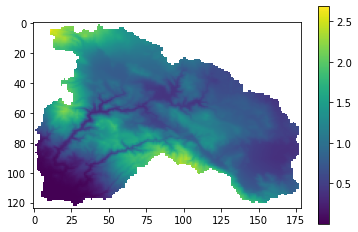

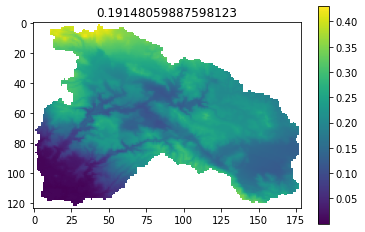

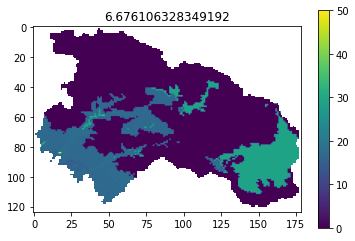

In [228]:
lagim1 = np.ma.masked_where(np.isnan(corrim), lagim, np.nan)
lagim2 = np.ma.masked_where(pvalim>=0.1, lagim1, np.nan)

plt.imshow(imgmean); plt.colorbar(); plt.show()
plt.imshow(corrim); plt.title(np.nanmean(corrim)); plt.colorbar(); plt.show()
plt.imshow(lagim2); plt.title(np.nanmean(lagim2));plt.colorbar(); plt.show()

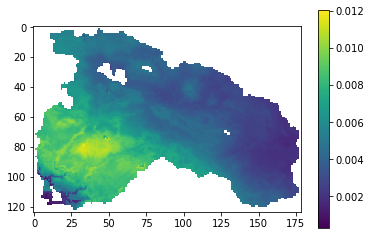

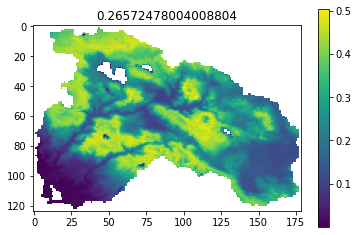

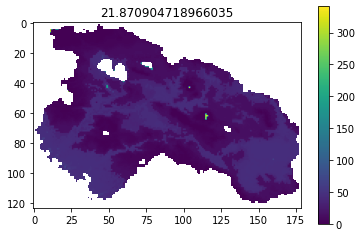

In [216]:
lagim1 = np.ma.masked_where(np.isnan(corrim), lagim, np.nan)
lagim2 = np.ma.masked_where(pvalim>=0.1, lagim1, np.nan)

plt.imshow(imgmean); plt.colorbar(); plt.show()
plt.imshow(corrim); plt.title(np.nanmean(corrim)); plt.colorbar(); plt.show()
plt.imshow(lagim2); plt.title(np.nanmean(lagim2));plt.colorbar(); plt.show()

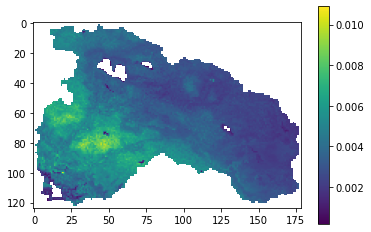

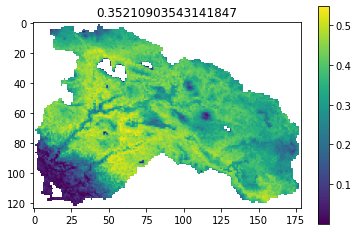

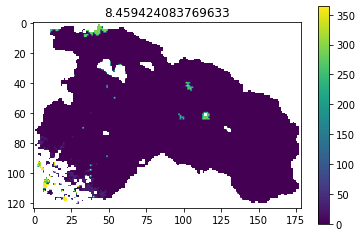

In [200]:
lagim1 = np.ma.masked_where(np.isnan(corrim), lagim, np.nan)
lagim2 = np.ma.masked_where(pvalim>=0.1, lagim1, np.nan)

plt.imshow(imgmean); plt.colorbar(); plt.show()
plt.imshow(corrim); plt.title(np.nanmean(corrim)); plt.colorbar(); plt.show()
plt.imshow(lagim2); plt.title(np.nanmean(lagim2));plt.colorbar(); plt.show()

0


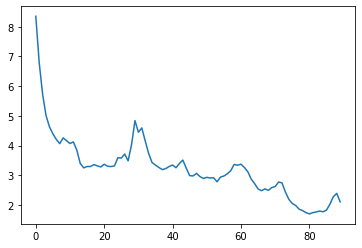

In [186]:
a = pxdf['8297'].values

A = fftpack.fft(normalize(a))
B = fftpack.fft(normalize(b))
Ar = -A.conjugate()
Br = -B.conjugate()

# print(np.argmax(np.abs(fftpack.ifft(Br*A))))
plt.plot(abs(fftpack.ifft(Ar*B))[:90])
print(np.argmax(np.abs(fftpack.ifft(Ar*B))[:90]))

In [193]:
find_peaks(np.abs(fftpack.ifft(Ar*B)), height = 3)[0] [:10]

array([ 8, 11, 15, 17, 20, 24, 26, 29, 31, 40])

In [72]:
print(np.argmax(abs(fftpack.ifft(Ar*B))))
print(np.argmax(abs(fftpack.ifft(Br*A))))

6574
1


<ipython-input-19-234091d1759d>:1: RuntimeWarning: Mean of empty slice
  plt.imshow(np.nanmean(imstack, axis = 2)); plt.colorbar(); plt.show()


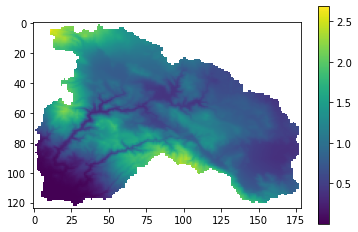

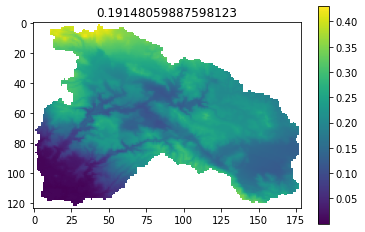

<ipython-input-19-234091d1759d>:3: RuntimeWarning: Mean of empty slice
  plt.imshow(lagim); plt.title(np.nanmean(lagim)); plt.colorbar(); plt.show()


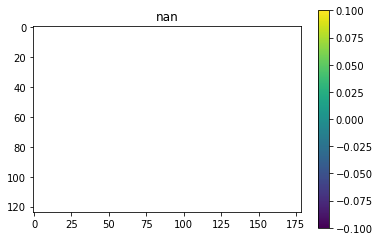

In [19]:
plt.imshow(np.nanmean(imstack, axis = 2)); plt.colorbar(); plt.show()
plt.imshow(corrim); plt.title(np.nanmean(corrim)); plt.colorbar(); plt.show()
plt.imshow(lagim); plt.title(np.nanmean(lagim)); plt.colorbar(); plt.show()

In [ ]:


# xcorr = sngial.correlate(A, B)

In [ ]:
def cross_correlation_using_fft(x, y):
    f1 = np.fft.fft(x)
    f2 = np.fft.fft(np.flipud(y))
    cc = np.real(np.fft.ifft(f1 * f2))
    return np.fft.fftshift(cc)

def compute_shift(x, y):
    assert len(x) == len(y)
    c = cross_correlation_using_fft(x, y)
    assert len(c) == len(x)
    zero_index = int(len(x) / 2) - 1
    shift = abs(zero_index - np.argmax(c))
    return shift


imstack = smlt.copy()
qarr = sr_df['ORO'].values

rows, cols, time = imstack.shape
px_ts = []
rclist = []

# extract pixelwise timeseries
for row in range(rows):
    for col in range(cols):
        ts_arr = imstack[row,col,:]

        if not np.isnan(ts_arr).all():
            px_ts.append(pd.Series(ts_arr))
            rclist.append([row,col])
        else:
            continue
#             px_ts.append(pd.Series(np.zeros_like(ts_arr)))
#             rclist.append([row,col])

pxdf = pd.concat(px_ts, axis = 1)
pxdf.columns = pxdf.columns.map(str)

# Build the out image
lagim = np.zeros_like(np.mean(imstack, axis = 2))
corrim = np.zeros_like(np.mean(imstack, axis = 2))
pvalim = np.zeros_like(np.mean(imstack, axis = 2))

# Populate the per-pixel lags 
for rc, dfcolidx in tqdm(list(zip(rclist,pxdf.columns))[1501:1502]):
    
    a=np.ma.masked_invalid(pxdf[dfcolidx])
    b=np.ma.masked_invalid(qarr)

    msk = (~a.mask & ~b.mask)

    # compute shift and correlation
    try:
        shiftval = compute_shift(a[msk],b[msk])
    except:
        shiftval = np.nan
        
    print(shiftval)
    
    try:
        corrcoef = stats.pearsonr(a,b)
        corr = corrcoef[0]
        pval = corrcoef[1]
    except:
        pval = np.nan
        corr = np.nan

    # fill ims
    rowidx, colidx = rc
    lagim[rowidx,colidx] = shiftval
    corrim[rowidx,colidx] = abs(corr)
    pvalim[rowidx,colidx] = pval

#     A_0=pxdf[dfcolidx].values
#     Ascaled = (A_0 - np.nanmean(A_0)) / np.nanstd(A_0)
#     A = np.where(np.isnan(Ascaled), Ascaled, 0)
#     Ascaled[np.isnan(Ascaled) = 0]
#     A = Ascaled.copy()
    
#     B=qarr.copy()
    
#     nsamples = A.size

#     # regularize datasets by subtracting mean and dividing by s.d.
#     A -= np.nanmean(A); A /= np.nanstd(A)
#     B -= np.nanmean(B); B /= np.nanstd(B)

#     # Find cross-correlation
#     xcorr = signal.correlate(A, B)

#     # delta time array to match xcorr
#     dt = np.arange(1-nsamples, nsamples)

#     recovered_time_shift = dt[xcorr.argmax()]

#     print("time shift: {}".format(recovered_time_shift))

    # compute shift + corr mag

#     A = fftpack.fft(A)
#     B = fftpack.fft(B)
#     Ar = -A.conjugate()
#     shiftval = np.argmax(np.abs(fftpack.ifft(Ar*B))) 
    
#     print(shiftval)
    
#     rowidx, colidx = rc
#     lagim[rowidx,colidx] = shiftval

    
#     # Shift
#     try:
#         A = fftpack.fft(normalize(a))
#         B = fftpack.fft(normalize(b))
#         Ar = -A.conjugate()
#         shiftval = np.argmax(np.abs(fftpack.ifft(Ar*B))[:]) 
#     except:
#         shiftval = np.nan

#     try:
#         corrcoef = stats.pearsonr(a,b)
#         corr = corrcoef[0]
#         pval = corrcoef[1]
#     except:
#         pval = np.nan
#         corr = np.nan

    # fill ims
#     rowidx, colidx = rc.al
#     corrim[rowidx,colidx] = abs(corr)
#     pvalim[rowidx,colidx] = pval


In [ ]:
def normalize(x):
	return(x-np.nanmin(x))/(np.nanmax(x)- np.nanmin(x))

a=np.ma.masked_invalid(pxdf[dfcolidx])
b=np.ma.masked_invalid(qarr)

xc = cross_correlation_using_fft(normalize(a[msk]),normalize(b[msk]))
plt.plot(xc)

In [ ]:
len(xc)

In [ ]:
# plt.plot(pxdf[dfcolidx])

arr = pxdf[dfcolidx]
arr[arr==np.nan] = 0

In [ ]:
plt.plot(np.where(pxdf[pxdf[dfcolidx] == np.nan ,pxdf[dfcolidx], 0))
# plt.plot(ab )

In [ ]:
def normalize(x):
	return(x-np.nanmin(x))/(np.nanmax(x)- np.nanmin(x))

imstack = prcp.copy()
imgmean = np.nanmean(imstack, axis = 2)

qarr = sr_df['ORO'].values
b=qarr.copy()

rows, cols, time = imstack.shape
px_ts = []
rclist = []

# extract pixelwise timeseries
for row in range(rows):
    for col in range(cols):
        
        if imgmean[row,col] == np.nan:
            continue
        else:
            ts_arr = imstack[row,col,:]
            px_ts.append(pd.Series(ts_arr))
            rclist.append([row,col])

#         if not np.isnan(ts_arr).all():
#             px_ts.append(pd.Series(ts_arr))
#             rclist.append([row,col])
#         else:
#             px_ts.append(pd.Series(np.zeros_like(ts_arr)))
#             rclist.append([row,col])

pxdf = pd.concat(px_ts, axis = 1)
pxdf.columns = pxdf.columns.map(str)

# pxdf.sample(n=30, axis = 1, random_state=1).plot()

# Build the out image
lagim = np.zeros_like(np.mean(imstack, axis = 2))
corrim = np.zeros_like(np.mean(imstack, axis = 2))
pvalim = np.zeros_like(np.mean(imstack, axis = 2))

# Populate the per-pixel lags 
for rc, dfcolidx in tqdm(list(zip(rclist,pxdf.columns))[:]):
    
    a=pxdf[dfcolidx].values
    
    A = fftpack.fft(normalize(a))
    B = fftpack.fft(normalize(b))
    Ar = -A.conjugate()
    shiftval = np.argmax(np.abs(fftpack.ifft(Ar*B))[:90]) 
    
    if not shiftval==0:
        print(shiftval)
    
    try:
        corrcoef = stats.pearsonr(a,b)
        corr = corrcoef[0]
        pval = corrcoef[1]
    except:
        pval = np.nan
        corr = np.nan

    # fill ims
    rowidx, colidx = rc
    lagim[rowidx,colidx] = shiftval
    corrim[rowidx,colidx] = abs(corr)
    pvalim[rowidx,colidx] = pval

In [ ]:
pxdf.sample(n=30, axis = 1, random_state=1).plot()

In [ ]:
plt.imshow(np.nanmean(imstack, axis = 2)); plt.colorbar(); plt.show()
plt.imshow(corrim); plt.colorbar(); plt.show()
plt.imshow(lagim); plt.colorbar(); plt.show()

In [ ]:
dfcolidx = '28340'
var_arr = pxdf[dfcolidx]

plt.plot(np.where(var_arr != np.nan, var_arr, 0))

In [ ]:
plt.plot(np.nan_to_num(var_arr,0))

In [ ]:
plt.imshow(corrim);plt.colorbar(); plt.title(np.nanmean(lagim)); plt.show()

In [ ]:
pxdf.sample(n=30, axis = 1, random_state=1).plot()

In [ ]:
# 

In [301]:

stn_id = "YRS"

p1 = rio.open("../results/moving_win_30/{}_prcp_sum.tif".format(stn_id)).read(1)
s1 = rio.open("../results/moving_win_30/{}_smlt_sum.tif".format(stn_id)).read(1)

# SURF RUNOFF COR
p2 = rio.open("../results/moving_win_30/{}_prcp_cor_sr.tif".format(stn_id)).read(1)
s2 = rio.open("../results/moving_win_30/{}_smlt_cor_sr.tif".format(stn_id)).read(1)

# SURF RUNOFF lag
p3 = rio.open("../results/moving_win_30/{}_prcp_lag_sr.tif".format(stn_id)).read(1)
s3 = rio.open("../results/moving_win_30/{}_smlt_lag_sr.tif".format(stn_id)).read(1)

# BF cor
p4 = rio.open("../results/moving_win_30/{}_prcp_cor_bf.tif".format(stn_id)).read(1)
s4 = rio.open("../results/moving_win_30/{}_smlt_cor_bf.tif".format(stn_id)).read(1)

# BF LAG
p5 = rio.open("../results/moving_win_30/{}_prcp_lag_bf.tif".format(stn_id)).read(1)
s5 = rio.open("../results/moving_win_30/{}_smlt_lag_bf.tif".format(stn_id)).read(1)


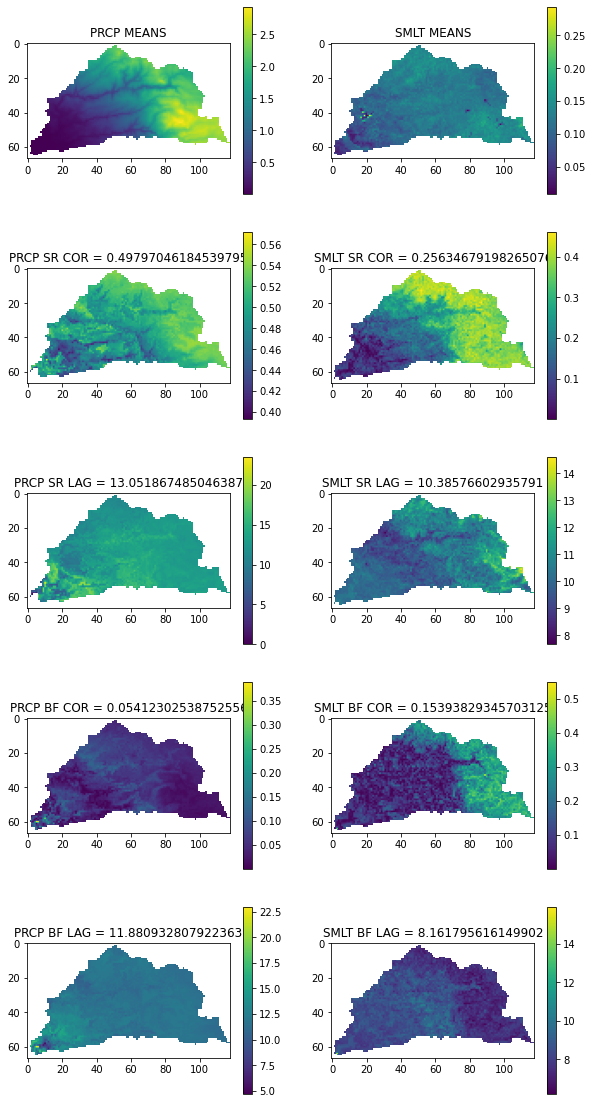

In [313]:
plt.figure(figsize = (10,20))

plt.subplot(521)
plt.title("PRCP MEANS")
plt.imshow(p1)
plt.colorbar()

plt.subplot(522)
plt.title("SMLT MEANS")
plt.imshow(s1*24)
plt.colorbar()

plt.subplot(523)
plt.title("PRCP SR COR = {}".format(np.nanmean(p2)))
plt.imshow(p2)
plt.colorbar()

plt.subplot(524)
plt.title("SMLT SR COR = {}".format(np.nanmean(s2)))
plt.imshow(s2)
plt.colorbar()

plt.subplot(525)
plt.title("PRCP SR LAG = {}".format(np.nanmean(p3)))
plt.imshow(p3)
plt.colorbar()

plt.subplot(526)
plt.title("SMLT SR LAG = {}".format(np.nanmean(s3)))
plt.imshow(s3)
plt.colorbar()

plt.subplot(527)
plt.title("PRCP BF COR = {}".format(np.nanmean(p4)))
plt.imshow(p4)
plt.colorbar()

plt.subplot(528)
plt.title("SMLT BF COR = {}".format(np.nanmean(s4)))
plt.imshow(s4)
plt.colorbar()


plt.subplot(529)
plt.title("PRCP BF LAG = {}".format(np.nanmean(p5)))
plt.imshow(p5)
plt.colorbar()

plt.subplot(5, 2, 10)
plt.title("SMLT BF LAG = {}".format(np.nanmean(s5)))
plt.imshow(s5)
plt.colorbar()


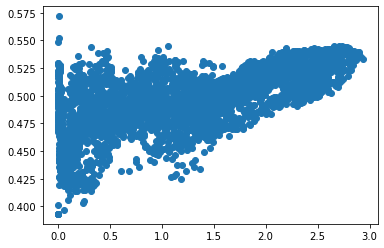

In [309]:
# plt.scatter(s1.flatten(), s2.flatten())
plt.scatter(p1.flatten(), p2.flatten()) 



# plt.scatter(s2.flatten(), s3.flatten())
# plt.scatter(s4.flatten(), s5.flatten())

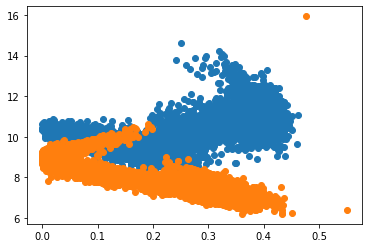

In [310]:

plt.scatter(s2.flatten(), s3.flatten())
plt.scatter(s4.flatten(), s5.flatten())

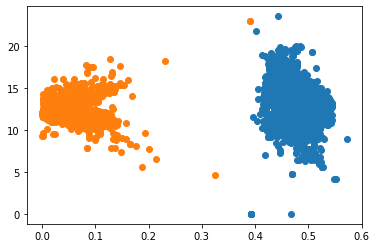

In [311]:
plt.scatter(p2.flatten(), p3.flatten())
plt.scatter(p4.flatten(), p5.flatten())

In [223]:
dt_idx = bf_df.index

window = (dt_idx[dt_idx > "2016-12-01"]& dt_idx[dt_idx <= "2017-02-10"])

ts = bf_df.copy()
ts['dt'] = ts.index
ts.reset_index(inplace = True)
start = ts[ts.dt == window[0]].index
end = ts[ts.dt == window[-1]].index

s, e = int(start.values), int(end.values)

smlt_ims = smlt[:,:,s:e+1]
prcp_ims = prcp[:,:,s:e+1]

smlt_anom = (np.nanmean(smlt_ims, axis = 2) - np.nanmean(smlt, axis = 2)) / np.nanmean(smlt, axis = 2)
prcp_anom = (np.nanmean(prcp_ims, axis = 2) - np.nanmean(prcp, axis = 2)) / np.nanmean(prcp, axis = 2)

plt.imshow(smlt_anom); plt.colorbar(); plt.show()
plt.imshow(prcp_anom); plt.colorbar(); plt.show()


<ipython-input-223-77eb3fb5ed15>:3: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  window = (dt_idx[dt_idx > "2016-12-01"]& dt_idx[dt_idx <= "2017-02-10"])


In [224]:
ts = bf_df.copy()
ts['dt'] = ts.index
ts.reset_index(inplace = True)
start = ts[ts.dt == window[0]].index
end = ts[ts.dt == window[-1]].index

s, e = int(start.values), int(end.values)

In [225]:
smlt_ims = smlt[:,:,s:e+1]
prcp_ims = prcp[:,:,s:e+1]


<ipython-input-226-c8243b8b32c0>:1: RuntimeWarning: Mean of empty slice
  smlt_anom = (np.nanmean(smlt_ims, axis = 2) - np.nanmean(smlt, axis = 2)) / np.nanmean(smlt, axis = 2)
<ipython-input-226-c8243b8b32c0>:2: RuntimeWarning: Mean of empty slice
  prcp_anom = (np.nanmean(prcp_ims, axis = 2) - np.nanmean(prcp, axis = 2)) / np.nanmean(prcp, axis = 2)


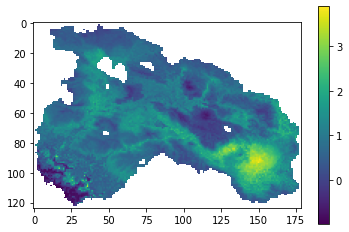

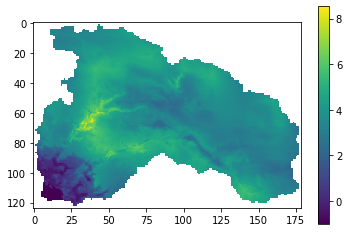

In [226]:
smlt_anom = (np.nanmean(smlt_ims, axis = 2) - np.nanmean(smlt, axis = 2)) / np.nanmean(smlt, axis = 2)
prcp_anom = (np.nanmean(prcp_ims, axis = 2) - np.nanmean(prcp, axis = 2)) / np.nanmean(prcp, axis = 2)

plt.imshow(smlt_anom); plt.colorbar(); plt.show()
plt.imshow(prcp_anom); plt.colorbar(); plt.show()


In [ ]:
plt.imshow(prcp_anom); plt.colorbar(); plt.show()

In [ ]:
    # Read watershed gdf
    stn_gdf = gp.read_file("../shape/{}.shp".format(stn_id))


    # Assign seasons to months
    shed_ts['month'] = shed_ts.index.month
    seasons = {10:'F', 11:'F', 12:'F', 1:'W', 2:'W', 3:'W', 4:'Sp', 5:'Sp', 6:'Sp',7:'Su',8:'Su',9:'Su'}
    shed_ts['Season'] = shed_ts['month'].apply(lambda x: seasons[x])

    # Map season to hydro year position
    seas_2_hy = {"F": "1", "W": "2", "Sp":"3", "Su":"4"}

    
    dt_idx = pd.date_range('2003-10-01','2021-09-30', freq='D')
    years = range(2003, 2022)

    for y in tqdm(list(years)[:]):
        ydf = shed_ts[shed_ts.index.year == y]

        for season in list(ydf.Season.unique()):

            # We limit the time window to HY 2021 
            if y == 2021 and season == "F": 
                continue

            # Select the season from year df
            sdf = ydf[ydf.Season==season]

            # Get starting and ending indices of that season and subset data 
            t1 = sdf.index[0]
            t2 = sdf.index[-1]
            window = (dt_idx[dt_idx > t1]& dt_idx[dt_idx <= t2])

            # Copy the df for indices to filter the array
            ts = shed_ts.copy()
            ts['dt'] = ts.index
            ts.reset_index(inplace = True)
            start = ts[ts.dt == window[0]].index
            end = ts[ts.dt == window[-1]].index

            s, e = int(start.values), int(end.values)

            # sum the var during that season
            hvar_sum = np.nansum(imstack[:,:,s:e+1], axis =2)

            # Calc lag, cor, MI 
            print("==========" * 5 )
            print(y, season)
            print("==========" * 5 )

            qarr_in = shed_ts.loc[window][stn_id].interpolate(how = 'linear').values

            # setup outfiles
            seas2hy = {"F":"1","W":"2","Sp":"3","Su":"4"}
            hy_idx = seas2hy[season]
            if season == "F":
                hy = y+1
            else:
                hy = y
                
            # setup seasons dir
            if not os.path.exists("../results/seasons"):
                os.mkdir("../results/seasons")

            # setup outfiles 
            outdir = "../results/seasons/seasonal_timeseries_test"
            
            if not os.path.exists(outdir):
                os.mkdir(outdir)

            hvar_sum_fn = os.path.join(outdir,"{}_{}_sum_{}_{}.tif".format(stn_id,hvar,hy_idx,str(hy)))
            hvar_pval_fn = os.path.join(outdir,"{}_{}_pval_{}_{}.tif".format(stn_id,hvar,hy_idx,str(hy)))
            # hvar_mi_fn = os.path.join(outdir,"{}_{}_mi_{}_{}.tif".format(stn_id,hvar,hy_idx,str(hy)))
            hvar_lag_fn = os.path.join(outdir,"{}_{}_lag_{}_{}.tif".format(stn_id,hvar,hy_idx,str(hy)))
            hvar_cor_fn = os.path.join(outdir,"{}_{}_cor_{}_{}.tif".format(stn_id,hvar,hy_idx,str(hy)))

            hvar_filelist = [hvar_sum_fn, hvar_lag_fn, hvar_cor_fn]

            # If they don't process and write
            if not all([os.path.isfile(f) for f in hvar_filelist]):
                hvar_lag, hvar_corr, hvar_pval = fft_wrapper(imstack[:,:,s:e+1], qarr_in)
                print('{} lag = {}'.format(hvar, str(np.nanmean(hvar_lag))))

                # hvar_mi = mi_wrapper(imstack[:,:,s:e+1], shed_ts.loc[window][stn_id].interpolate(how = 'linear'))

                write_raster(hvar_lag, stn_gdf, hvar_lag_fn)
                write_raster(hvar_corr, stn_gdf, hvar_cor_fn)
                write_raster(hvar_pval, stn_gdf, hvar_pval_fn)
                # write_raster(hvar_mi, stn_gdf, hvar_mi_fn)
                write_raster(hvar_sum, stn_gdf, hvar_sum_fn)
